In [1]:
import torch.nn as nn
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import chess

import src.chess_trainer as trainer
import src.preprocessing as preprocessing
import src.compare as compare
import src.nn_models as nn_models

In [2]:
df = pd.read_csv("data/cleaned/chess_train_val_small.csv")

In [3]:
y = df["advantage"].to_numpy(dtype=np.float32)
fens = df["canonical_fen"]
path = Path("scratch/X_small.dat")

X = preprocessing.build_memmap(fens, path, np.float32, override=True)

building memmap: 100%|██████████| 1285186/1285186 [00:16<00:00, 78518.62it/s]


# Transformation of target

I don't know if we should transform the target. The untransformed target has very long tails, but I also created them myself, so that the model can hopefully mating.
Here are all the options: no transform, arcsinh, signed_log, tanh.

I think signed_log and tanh are out of the race.

I don't really have time to compare the performance of models using untransformed and arcsinh targets. So I will just go with arcsinh because I heard it's good to get rid of long tails, but I'm not sure about it.

<Axes: ylabel='Count'>

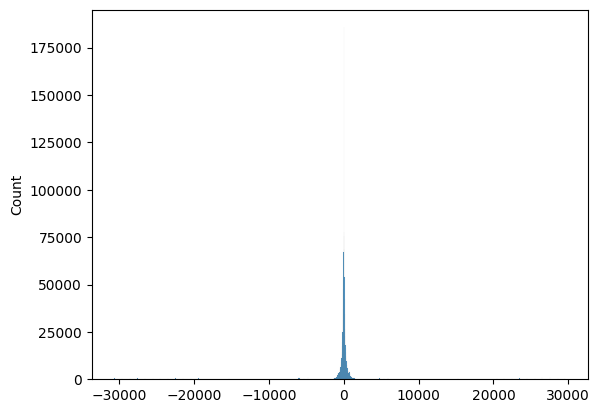

In [10]:
# original target has very long tail

sns.histplot(y)

<Axes: ylabel='Count'>

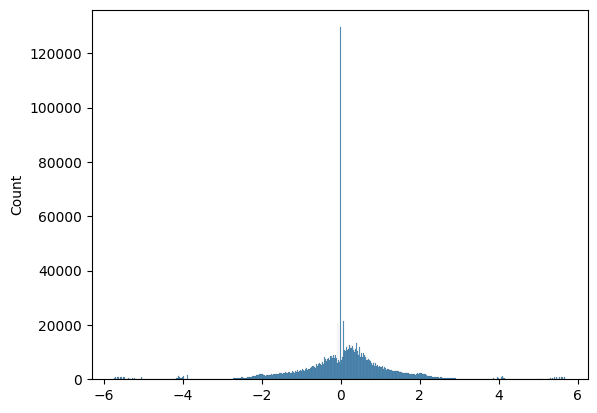

In [14]:
# using an asinh transform has less of a tail

y_arcsinh = np.arcsinh(y / 200.0)
sns.histplot(y_arcsinh)

<Axes: ylabel='Count'>

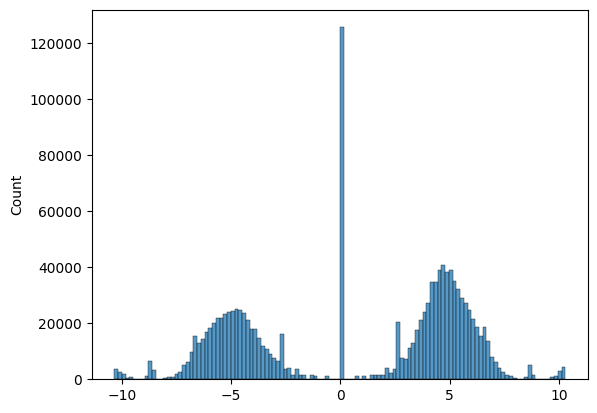

In [6]:
# with signed_log I think distortion around 0 is too big

y_signed_log = np.sign(y) * np.log(np.abs(y) + 1)
sns.histplot(y_signed_log)

<Axes: ylabel='Count'>

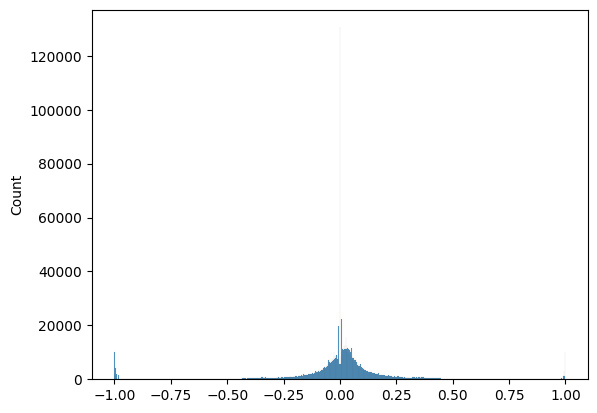

In [8]:
# tanh looks also good but clipps more to the extremes -1,1

y_tanh = np.tanh(y / 2000)
sns.histplot(y_tanh)

# NN Models and losses

The models created my an LLM are in `nn_models.py`.
Here are possible losses that we take under consideration:

In [12]:
# classic: Mean squared error, sensitive to outliers
loss_mse = nn.MSELoss()

# less outlier punishment
loss_mae = nn.L1Loss()

# mix: mse for small errors, mae for large errors
loss_hubner = nn.SmoothL1Loss()

# Compare Loss Function

In [15]:
models_loss = {}

for title, loss_fn in [("mse", loss_mse), ("mae", loss_mae), ("hubner", loss_hubner)]:
    print(f"==={title}===")
    nn = nn_models.SmallCNNFast()
    models = trainer.train(
        X,
        y_arcsinh,
        nn,
        lr=1e-3,
        epochs=10,
        load_workers=1,
        batch_size=4096,
        val_split=0.01,
        seed=0,
        loss_function=loss_fn,
    )
    models_loss[title] = models[0]
    print("\n")

===mse===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00,  8.68batches/s, avg_loss=1.15]


  train_loss=1.291151  val_loss=1.153625
PARAM CHANGE (average): 22.6813
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 49.07batches/s, avg_loss=1.02]


  train_loss=1.089435  val_loss=1.018813
PARAM CHANGE (average): 11.8921
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 35.65batches/s, avg_loss=0.971]


  train_loss=1.018119  val_loss=0.970941
PARAM CHANGE (average): 8.63223
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 49.82batches/s, avg_loss=0.928]


  train_loss=0.976583  val_loss=0.927990
PARAM CHANGE (average): 6.64515
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 53.55batches/s, avg_loss=0.91]


  train_loss=0.951481  val_loss=0.910256
PARAM CHANGE (average): 5.06117
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 51.53batches/s, avg_loss=0.908]


  train_loss=0.933586  val_loss=0.908201
PARAM CHANGE (average): 3.68129
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 53.67batches/s, avg_loss=0.897]


  train_loss=0.920599  val_loss=0.897177
PARAM CHANGE (average): 2.57892
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 44.58batches/s, avg_loss=0.889]


  train_loss=0.911802  val_loss=0.889251
PARAM CHANGE (average): 1.53493
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 53.63batches/s, avg_loss=0.882]


  train_loss=0.906262  val_loss=0.882313
PARAM CHANGE (average): 0.757072
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 52.98batches/s, avg_loss=0.884]


  train_loss=0.903603  val_loss=0.884466
PARAM CHANGE (average): 0.221908
Total training time: 0 hours and 3 minutes


===mae===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 24.90batches/s, avg_loss=0.721]


  train_loss=0.763321  val_loss=0.721071
PARAM CHANGE (average): 20.7953
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 48.46batches/s, avg_loss=0.693]


  train_loss=0.705584  val_loss=0.693010
PARAM CHANGE (average): 12.85
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 48.83batches/s, avg_loss=0.663]


  train_loss=0.676793  val_loss=0.663012
PARAM CHANGE (average): 10.5684
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 48.06batches/s, avg_loss=0.641]


  train_loss=0.657479  val_loss=0.640876
PARAM CHANGE (average): 7.75785
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 50.60batches/s, avg_loss=0.632]


  train_loss=0.645558  val_loss=0.632334
PARAM CHANGE (average): 5.87521
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 51.24batches/s, avg_loss=0.63]


  train_loss=0.637133  val_loss=0.630188
PARAM CHANGE (average): 4.7532
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 47.80batches/s, avg_loss=0.623]


  train_loss=0.628927  val_loss=0.622586
PARAM CHANGE (average): 3.83978
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 43.28batches/s, avg_loss=0.617]


  train_loss=0.622907  val_loss=0.616869
PARAM CHANGE (average): 2.13473
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 51.19batches/s, avg_loss=0.613]


  train_loss=0.619345  val_loss=0.613173
PARAM CHANGE (average): 0.968887
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 48.15batches/s, avg_loss=0.614]


  train_loss=0.617743  val_loss=0.613904
PARAM CHANGE (average): 0.266743
Total training time: 0 hours and 3 minutes


===hubner===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 23.49batches/s, avg_loss=0.395]


  train_loss=0.432797  val_loss=0.394584
PARAM CHANGE (average): 21.6396
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 48.61batches/s, avg_loss=0.359]


  train_loss=0.379796  val_loss=0.359002
PARAM CHANGE (average): 14.1772
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 48.61batches/s, avg_loss=0.342]


  train_loss=0.354660  val_loss=0.341662
PARAM CHANGE (average): 10.0801
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 50.07batches/s, avg_loss=0.329]


  train_loss=0.340504  val_loss=0.329367
PARAM CHANGE (average): 8.33689
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 49.68batches/s, avg_loss=0.322]


  train_loss=0.331324  val_loss=0.322376
PARAM CHANGE (average): 5.87838
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 49.51batches/s, avg_loss=0.32]


  train_loss=0.325368  val_loss=0.320415
PARAM CHANGE (average): 4.17154
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 48.71batches/s, avg_loss=0.317]


  train_loss=0.320919  val_loss=0.317052
PARAM CHANGE (average): 2.81803
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 49.01batches/s, avg_loss=0.315]


  train_loss=0.318021  val_loss=0.314795
PARAM CHANGE (average): 1.68598
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 54.23batches/s, avg_loss=0.312]


  train_loss=0.316292  val_loss=0.312208
PARAM CHANGE (average): 0.826448
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 51.46batches/s, avg_loss=0.312]


  train_loss=0.315575  val_loss=0.312292
PARAM CHANGE (average): 0.236293
Total training time: 0 hours and 3 minutes




When comparing these models the results are actually inconclusive (difference most likely just random noise).

Maybe with more data a proper decision could be made or longer training or... well... I don't have got time for this. We will just stick with `loss_hubner` (that's my expert decision :D) and move on

In [33]:
model1 = nn_models.SmallCNNFast()
model2 = nn_models.SmallCNNFast()

for m1, m2 in [("mse", "mae"), ("mse", "hubner"), ("mae", "hubner")]:
    model1.load_state_dict(models_loss[m1])
    model2.load_state_dict(models_loss[m2])
    agent1 = compare.PyTorchAgent(model1)
    agent2 = compare.PyTorchAgent(model2)
    print(f"{m1} vs {m2}: {compare.war(agent1, agent2, games_per_side=50)}")

mse vs mae: {'model1': 3, 'model2': 2, 'draw': 95}
mse vs hubner: {'model1': 1, 'model2': 2, 'draw': 97}
mae vs hubner: {'model1': 2, 'model2': 2, 'draw': 96}


To see what's going on let's check out some games. We can see that the two agents get stuck in a loop. That's actually easily explainable as the agents are deterministic, for that reason I play each game with a 10% chance of a random move for the first 20 turns.

Maybe another better metric for these bad models would maybe be to see the amount of material after a game.

Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
8/4K2p/1k5P/p7/P7/5p2/8/8 b - - 32 59


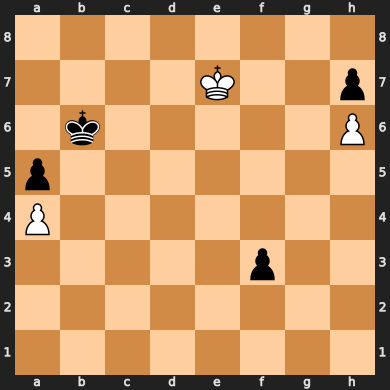

In [51]:
# let's check out some games

model1.load_state_dict(models_loss["mse"])
model2.load_state_dict(models_loss["hubner"])
agent1 = compare.PyTorchAgent(model1)
agent2 = compare.PyTorchAgent(model2)

outcome, final_board = compare.fight(agent1, agent2, 0.1, 20)
print(outcome)
print(final_board)
chess.Board(final_board)

Outcome(termination=<Termination.INSUFFICIENT_MATERIAL: 3>, winner=None)
8/8/8/4kB2/8/8/8/4K3 w - - 0 41


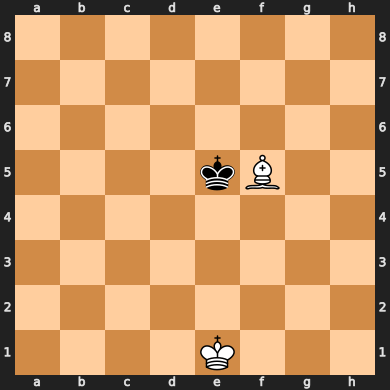

In [52]:
outcome, final_board = compare.fight(agent1, agent2, 0.1, 20)
print(outcome)
print(final_board)
chess.Board(final_board)

Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
8/8/1k1KP3/1p6/1P6/8/8/8 b - - 20 54


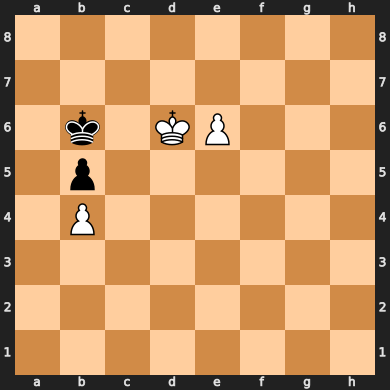

In [53]:
outcome, final_board = compare.fight(agent1, agent2, 0.1, 20)
print(outcome)
print(final_board)
chess.Board(final_board)

Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
8/3K4/7p/8/p7/P3kp1p/7P/8 b - - 16 56


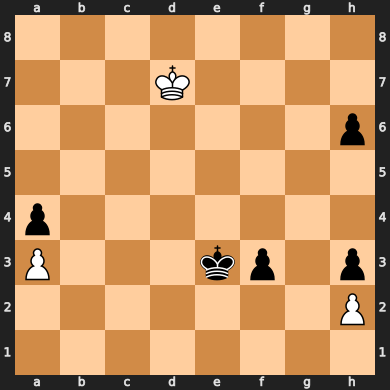

In [54]:
outcome, final_board = compare.fight(agent1, agent2, 0.1, 20)
print(outcome)
print(final_board)
chess.Board(final_board)

Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
3Q4/8/8/8/1PP5/8/4k3/7K w - - 24 70


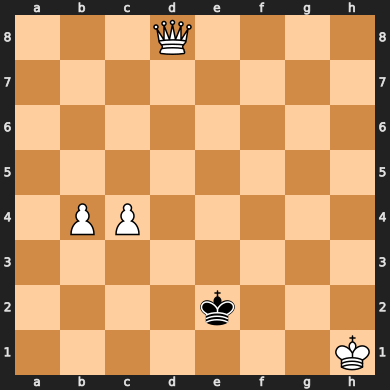

In [55]:
outcome, final_board = compare.fight(agent1, agent2, 0.1, 20)
print(outcome)
print(final_board)
chess.Board(final_board)

After this I just realized a problem in this approach. A trained model will most likely have troubles distinguishing very good positions from each other, i.e., it won't favour positions that lead to a mate over positions that lead to a mate but just later.

# Compare Transforms

unlikely that this will be any more enlightening, but I want to try it anyway :D

In [34]:
models_transform = {}

for title, y_t in [("identity", y), ("asinh", y_arcsinh)]:
    print(f"==={title}===")
    model = nn_models.SmallCNNFast()
    models = trainer.train(
        X,
        y_t,
        model,
        seed=0,
        lr=1e-3,
        epochs=10,
        val_split=0.01,
        load_workers=1,
        batch_size=4096,
        loss_function=loss_hubner,
    )
    models_transform[title] = models[0]
    print("\n")

===identity===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 16.12batches/s, avg_loss=616]


  train_loss=641.352485  val_loss=616.042126
PARAM CHANGE (average): 66.7831
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 13.45batches/s, avg_loss=604]


  train_loss=624.923511  val_loss=603.535038
PARAM CHANGE (average): 23.5605
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 15.45batches/s, avg_loss=595]


  train_loss=615.578927  val_loss=594.736138
PARAM CHANGE (average): 18.7549
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 20.04batches/s, avg_loss=589]


  train_loss=609.694107  val_loss=589.219454
PARAM CHANGE (average): 13.6559
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 16.97batches/s, avg_loss=586]


  train_loss=605.897796  val_loss=585.620493
PARAM CHANGE (average): 10.4148
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 12.13batches/s, avg_loss=583]


  train_loss=603.131776  val_loss=583.399059
PARAM CHANGE (average): 7.9204
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 14.16batches/s, avg_loss=582]


  train_loss=601.114194  val_loss=581.590444
PARAM CHANGE (average): 5.47284
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 18.55batches/s, avg_loss=580]


  train_loss=599.674998  val_loss=580.314022
PARAM CHANGE (average): 3.4582
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 10.85batches/s, avg_loss=579]


  train_loss=598.791729  val_loss=579.230879
PARAM CHANGE (average): 1.70727
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 21.00batches/s, avg_loss=580]


  train_loss=598.590322  val_loss=579.619410
PARAM CHANGE (average): 0.460199
Total training time: 0 hours and 6 minutes


===asinh===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00,  8.75batches/s, avg_loss=0.395]


  train_loss=0.432797  val_loss=0.394584
PARAM CHANGE (average): 21.6396
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 15.51batches/s, avg_loss=0.359]


  train_loss=0.379796  val_loss=0.359002
PARAM CHANGE (average): 14.1772
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 21.84batches/s, avg_loss=0.342]


  train_loss=0.354660  val_loss=0.341662
PARAM CHANGE (average): 10.0801
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 21.29batches/s, avg_loss=0.329]


  train_loss=0.340504  val_loss=0.329367
PARAM CHANGE (average): 8.33689
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 14.63batches/s, avg_loss=0.322]


  train_loss=0.331324  val_loss=0.322376
PARAM CHANGE (average): 5.87838
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 12.00batches/s, avg_loss=0.32] 


  train_loss=0.325368  val_loss=0.320415
PARAM CHANGE (average): 4.17154
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 12.53batches/s, avg_loss=0.317]


  train_loss=0.320919  val_loss=0.317052
PARAM CHANGE (average): 2.81803
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 15.52batches/s, avg_loss=0.315]


  train_loss=0.318021  val_loss=0.314795
PARAM CHANGE (average): 1.68598
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 25.51batches/s, avg_loss=0.312]


  train_loss=0.316292  val_loss=0.312208
PARAM CHANGE (average): 0.826448
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 15.92batches/s, avg_loss=0.312]


  train_loss=0.315575  val_loss=0.312292
PARAM CHANGE (average): 0.236293
Total training time: 0 hours and 6 minutes




Well, this also is inconclusive. That calls for an expert decision once more. Let's stick with `asinh`

In [43]:
all = ["identity", "asinh"]

# I included same vs same just so we can see how much lucks decides in these games
for i in range(len(all)):
    m1 = all[i]
    for j in range(i, len(all)):
        m2 = all[j]
        model1.load_state_dict(models_transform[m1])
        model2.load_state_dict(models_transform[m2])
        agent1 = compare.PyTorchAgent(model1)
        agent2 = compare.PyTorchAgent(model2)

        print(f"{m1} vs {m2}: {compare.war(agent1, agent2, games_per_side=50)}")

identity vs identity: {'model1': 2, 'model2': 2, 'draw': 96}
identity vs asinh: {'model1': 7, 'model2': 1, 'draw': 92}
asinh vs asinh: {'model1': 1, 'model2': 4, 'draw': 95}


# Compare NN Models

Training NN models takes too long. So I do this with the main script for providing the final model

In [82]:
import onnxruntime
import src.play as play

agent_small = play.load_onnx_agent(
    "models/chess_eval-full_data-small_model-4_epochs.onnx"
)
agent_medium = play.load_onnx_agent(
    "models/chess_eval-full_data-medium_model-2_epochs.onnx"
)
agent_large = play.load_onnx_agent(
    "models/chess_eval-full_data-large_model-1_epochs.onnx"
)

print(f"small vs medium: {compare.war(agent_small, agent_medium, games_per_side=100)}")

print(f"small vs large: {compare.war(agent_small, agent_large, games_per_side=100)}")

print(f"medium vs large: {compare.war(agent_medium, agent_large, games_per_side=100)}")

small vs medium: {'model1': 13, 'model2': 24, 'draw': 163}
small vs large: {'model1': 20, 'model2': 20, 'draw': 160}
medium vs large: {'model1': 9, 'model2': 13, 'draw': 178}


Again, it looks just like random noise. It's just that the models don't mate I suppose. We can see this in particular if we look at the final boards:

Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
3K4/5k1p/2p1p2P/p2pPn2/1P3P2/2P5/1q6/4q3 w - - 17 49


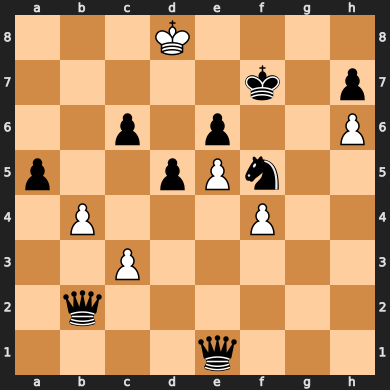

In [83]:
outcome, final_board = compare.fight(agent_small, agent_large, 0.1, 20)
print(outcome)
print(final_board)
chess.Board(final_board)

Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
8/5k2/3K4/7P/1p4PP/1P6/6R1/8 w - - 19 52


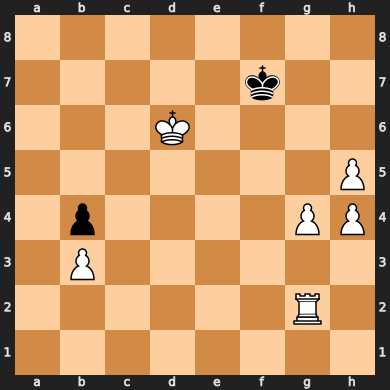

In [84]:
outcome, final_board = compare.fight(agent_small, agent_large, 0.1, 20)
print(outcome)
print(final_board)
chess.Board(final_board)

Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
8/1pp5/3k4/8/1P6/3PK3/6q1/8 b - - 19 56


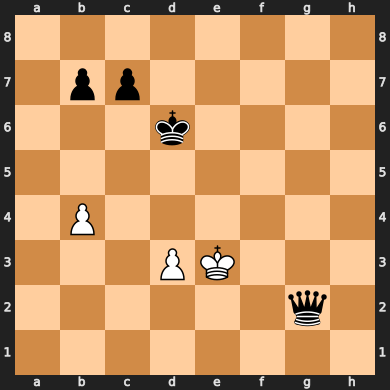

In [85]:
outcome, final_board = compare.fight(agent_small, agent_large, 0.1, 20)
print(outcome)
print(final_board)
chess.Board(final_board)

Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
8/2k5/2n2KP1/1b3p2/8/q7/8/r3q3 w - - 30 66


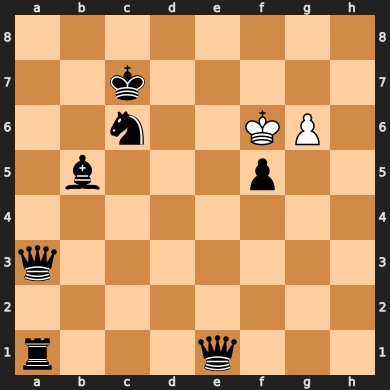

In [86]:
outcome, final_board = compare.fight(agent_small, agent_large, 0.1, 20)
print(outcome)
print(final_board)
chess.Board(final_board)